# Eigenfluid Control Force Optimization

In this notebook, we optimize for a control force vector $\textbf{f} \in \mathbb{R}^{t \times N}$, where $t$ is the number of timesteps simulated, and $N$ is the number of basis coefficients in the Eigenfluid simulation.

$\text{Loss}(\textbf{p}_0, \textbf{p}_t, \textbf{f}, \textbf{w}_0) = 
\left|\left|
    (\mathcal{P}\circ\mathcal{F}_f)^t(\textbf{p}_0, \textbf{w}_0) - \textbf{p}_t
\right|\right|_2^2$

TIME_STEPS is fixed (=16)

### Uncomment this when Running in Colab

In [ ]:
#!pip install --quiet phiflow==2.2.2
#import os
#if not os.path.isdir('eigenfluid-control'):
#  print("Cloning eigenfluid-control repo, this can take a moment")
#  os.system("git clone https://github.com/bobarna/eigenfluid-control")
#import sys; sys.path.append('eigenfluid-control')

## Imports & Initialization

In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
from src.shapes import *

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 5.884675025939941 seconds


# Initialize Start and Target Points

<Figure size 216x216 with 1 Axes>

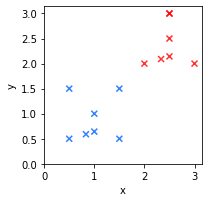

In [55]:
shape_0 = Square(pos=(0.5, 0.5))
shape_target = Triangle(pos=(2, 2))

# Get O overlapping, and U non-necessarily overlapping ('unique') sample points
O = 1
U = 1

p_0, p_t = get_points_for_shapes(shape_0, shape_target, O, U)

p_0 = concat([p_0, shape_0.create_points(shape_0.get_trivial_points())], instance('i'))
p_t = concat([p_t, shape_target.create_points(shape_target.get_trivial_points())], instance('i'))

plot({"Blue: start\nRed: target": 
     vis.overlay(
        PointCloud(p_0, bounds=DOMAIN),
        PointCloud(p_t, bounds=DOMAIN, color="red")
     )},
     size=(3,3)
)

# Loss Function

In [4]:
STEPS = 16
DT    = 0.2
VISCOSITY = 0.0

# Initialize the force vector to zero
f_optim = math.zeros(eigenfluid.w.shape & batch(time=STEPS-1))

def loss_function(f_optim, w, p, p_target):
    trajectory_p = [p]
    for t in range(STEPS-1):
        # Step velocity
        w = eigenfluid.step_w_euler(w, DT, viscosity=VISCOSITY)
        # Add control forces
        w += f_optim.time[t]
        # Get velocities at new positions
        v_phi = eigenfluid.phi_template(w, eigenfluid.N, eigenfluid.basis_fields)
        p_velocities = v_phi(p)
        # Midpoint
        p_velocities = v_phi(p + p_velocities*DT/2)
        # Euler step for points
        p += p_velocities * DT
        trajectory_p.append(p)
    # Normalizing by the number of sample points
    loss = field.l2_loss(p - p_target) / p.i.size
    return (loss, trajectory_p)

gradient_function = math.gradient(loss_function)

In [5]:
w_init = eigenfluid.w

# first gradient
(loss, trajectory_p), grad = gradient_function(f_optim, w_init, p_0, p_t)
print("Initial Loss: {}".format(loss))

Initial Loss: 2.3182316


In [6]:
LR = 10**-2

grads = [0] #initialize to 0 for momentum

for optim_step in range(101):
    (loss, trajectory_p), grad = gradient_function(f_optim, w_init, p_0, p_t)
    if optim_step%3 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    if optim_step == 41:
        LR /= 2
        print("LR = {}".format(LR))
        
    grads.append( grad[0] )

    # optionally with momentum
    f_optim = f_optim - LR * (grads[-1] + 0.85*grads[-2]) 

Optimization step 0, loss: 2.318232
Optimization step 1, loss: 1.945772
Optimization step 2, loss: 1.386693
Optimization step 3, loss: 0.991361
Optimization step 4, loss: 0.725080
Optimization step 6, loss: 0.479465
Optimization step 9, loss: 0.290514
Optimization step 12, loss: 0.195686
Optimization step 15, loss: 0.145834
Optimization step 18, loss: 0.118416
Optimization step 21, loss: 0.101609
Optimization step 24, loss: 0.090290
Optimization step 27, loss: 0.082120
Optimization step 30, loss: 0.075894
Optimization step 33, loss: 0.070940
Optimization step 36, loss: 0.066861
Optimization step 39, loss: 0.063413
LR = 0.005
Optimization step 42, loss: 0.060909
Optimization step 45, loss: 0.059548
Optimization step 48, loss: 0.058269
Optimization step 51, loss: 0.057064
Optimization step 54, loss: 0.055924
Optimization step 57, loss: 0.054845
Optimization step 60, loss: 0.053820
Optimization step 63, loss: 0.052845
Optimization step 66, loss: 0.051917
Optimization step 69, loss: 0.0510

In [8]:
trajectory_p = math.stack(trajectory_p, batch('time'))
target_time = math.stack([p_t]*STEPS, batch('time'))

vis.plot({ 
    "trajectory": vis.overlay(
        PointCloud(trajectory_p, bounds=DOMAIN),
        PointCloud(target_time, bounds=DOMAIN, color="red")
    )},
    animate='time',
    same_scale=False,
    size=(4,4),
    frame_time=150
)

<Figure size 432x288 with 0 Axes>

In [9]:
# Generate smoke trajectory
smoke_traj = [shape_0.get_smoke()]
w = w_init

for t in range(STEPS-1):
    # Step velocity
    w = eigenfluid.step_w_euler(w, DT, viscosity=VISCOSITY)
    # Add control forces
    w += f_optim.time[t]
    
    velocity = eigenfluid.reconstruct_velocity(w)
    smoke = advect.mac_cormack(smoke_traj[-1], velocity, dt=DT)
    smoke_traj.append(smoke)

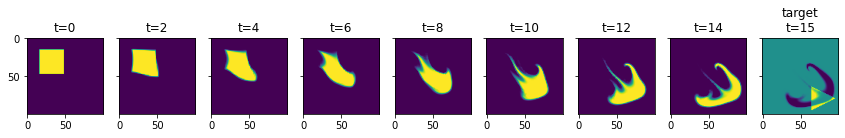

In [14]:
target_smoke = shape_target.get_smoke()

pylab.subplots(1, 9, sharey='row', sharex='col', figsize=(12, 7))
pylab.tight_layout(w_pad=0)
for t in range(9):
    pylab.subplot(1, 9, (t+1))
    if t == 8:
        pylab.title('target\nt=15')
        pylab.imshow(target_smoke.values - smoke_traj[-1].values, origin='upper')
    else:
        pylab.title('t={}'.format(t*2))
        pylab.imshow(smoke_traj[(t*2)].values, origin='upper')

In [41]:
trajectory_p

(timeᵇ=16, iⁱ=7, vectorᶜ=x,y) 1.497 ± 0.665 (5e-01...3e+00)

<Figure size 864x360 with 9 Axes>

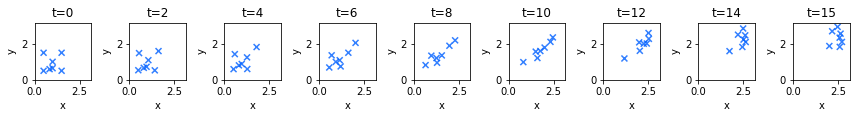

In [54]:
# Sorry clean code :(
time_steps = [0,2,4,6,8,10,12,14,15]
pointclouds = [PointCloud(trajectory_p.time[t], bounds=DOMAIN) for t in range(trajectory_p.time.size)]
plot_dict = {}
for t in time_steps:
    plot_dict["t={}".format(t)] = pointclouds[t]

vis.plot(
    plot_dict, bounds=DOMAIN
)